In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Found 553 images belonging to 2 classes.
Found 175 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


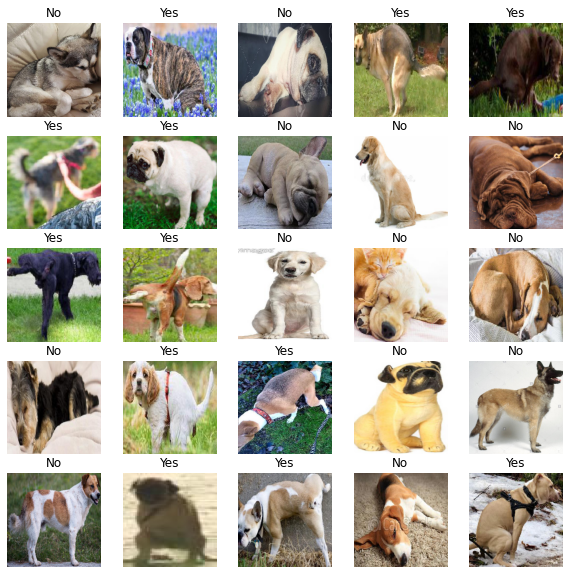

In [18]:
import tensorflow as tf
import numpy as np
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=50)


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

predict_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    # validation_split=0.2
)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
data_dir = '/content/gdrive/My Drive/soma/yn_test_data/'
data_dir = pathlib.Path(data_dir)
predict_dir = '/content/gdrive/My Drive/soma/yn_train_data/'
predict_dir = pathlib.Path(predict_dir)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')
                                                    #  subset = 'training')

predict_data_gen = predict_generator.flow_from_directory(directory=str(predict_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')
                                                    #  subset = 'training')


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

validation_generator = image_generator.flow_from_directory(
    directory=str(data_dir), # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes = list(CLASS_NAMES),
    class_mode='categorical',
    subset='validation') 


IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
res_net = tf.keras.applications.ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = IMG_SHAPE)

res_net.trainable = True

global_average_layer = layers.GlobalAveragePooling2D()
# relu_layer = layers.Dense(12, activation = 'relu')
# dropdout = layers.Dropout(0.2)
output_layer = layers.Dense(2, activation='softmax')




tl_model = tf.keras.models.Sequential([
  res_net,
  global_average_layer,
  output_layer
  # tf.keras.layers.Dense(12,activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(6,activation='softmax')
])



tl_model.summary()

tl_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


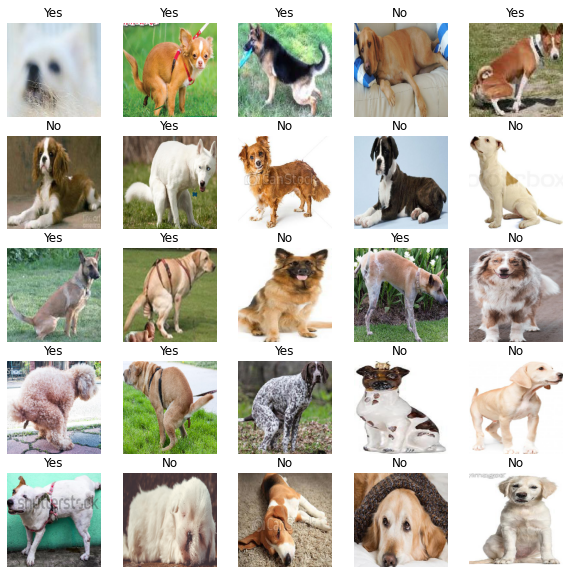

In [19]:
p_image_batch, p_label_batch = next(predict_data_gen)
show_batch(p_image_batch, p_label_batch)

In [20]:

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/transer_learning_model', update_freq='batch')]

tl_model.fit_generator(train_data_gen, 
             steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
             epochs=100,
            #  batch_size = BATCH_SIZE,
             validation_data=validation_generator,
             validation_steps = 2,
             callbacks=[es, mc]

             )

Epoch 1/100
17/17 [==============================] - 8s 493ms/step - loss: 0.8033 - accuracy: 0.7812 - val_loss: 723544.2500 - val_accuracy: 0.5000
Epoch 2/100
17/17 [==============================] - 8s 451ms/step - loss: 0.4403 - accuracy: 0.8484 - val_loss: 1020.5071 - val_accuracy: 0.4219
Epoch 3/100
17/17 [==============================] - 8s 456ms/step - loss: 0.3933 - accuracy: 0.8676 - val_loss: 2.0192 - val_accuracy: 0.5312
Epoch 4/100
17/17 [==============================] - 7s 433ms/step - loss: 0.1941 - accuracy: 0.9271 - val_loss: 1.2685 - val_accuracy: 0.5469
Epoch 5/100
17/17 [==============================] - 8s 443ms/step - loss: 0.1385 - accuracy: 0.9559 - val_loss: 0.9366 - val_accuracy: 0.4531
Epoch 6/100
17/17 [==============================] - 8s 461ms/step - loss: 0.1088 - accuracy: 0.9693 - val_loss: 0.7339 - val_accuracy: 0.5156
Epoch 7/100
17/17 [==============================] - 8s 455ms/step - loss: 0.1780 - accuracy: 0.9520 - val_loss: 0.6974 - val_accuracy

In [21]:
predict_batch, p_label_batch = next(predict_data_gen)
output = tl_model.predict_generator(predict_batch)
print(np.argmax(output)

[[4.95891950e-09 1.00000000e+00]
 [1.20155724e-04 9.99879837e-01]
 [9.99631047e-01 3.68893147e-04]
 [9.99936819e-01 6.31687435e-05]
 [2.52802624e-06 9.99997497e-01]
 [9.99940991e-01 5.89976953e-05]
 [1.06376547e-06 9.99998927e-01]
 [9.99999642e-01 4.05523281e-07]
 [7.65367091e-01 2.34632909e-01]
 [2.75072671e-04 9.99724925e-01]
 [1.78298995e-01 8.21701050e-01]
 [2.30856473e-03 9.97691512e-01]
 [3.59634781e-04 9.99640346e-01]
 [9.99542713e-01 4.57301096e-04]
 [9.99999523e-01 4.22186446e-07]
 [1.41956407e-05 9.99985814e-01]
 [1.00000000e+00 4.55199878e-10]
 [2.82993482e-04 9.99716938e-01]
 [1.08509639e-05 9.99989152e-01]
 [9.99987721e-01 1.22706897e-05]
 [9.99935508e-01 6.45331675e-05]
 [9.99985456e-01 1.45600752e-05]
 [8.89805742e-05 9.99911070e-01]
 [9.99980569e-01 1.94068325e-05]
 [9.99910831e-01 8.91208547e-05]
 [3.88002409e-05 9.99961257e-01]
 [5.79423386e-06 9.99994159e-01]
 [9.99884725e-01 1.15286268e-04]
 [7.35277035e-06 9.99992609e-01]
 [2.24632674e-10 1.00000000e+00]
 [9.999998

In [23]:
print(p_label_batch)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [22]:
for elem in output :
  if (np.max(elem) >= 0.8) :
    print(CLASS_NAMES[np.argmax(elem)])
  else :
    print("none")

no
no
yes
yes
no
yes
no
yes
none
no
no
no
no
yes
yes
no
yes
no
no
yes
yes
yes
no
yes
yes
no
no
yes
no
no
yes
no


IndexError: ignored

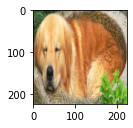

In [ ]:
show_batch(predict_batch, p_label_batch)


In [32]:
predicted=tl_model.predict_classes(predict_batch)
confusion = tf.math.confusion_matrix(labels=np.argmax(p_label_batch,axis=1), predictions=predicted, num_classes=2)
confusion

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14,  0],
       [ 1, 17]], dtype=int32)>

In [33]:
predicted

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [34]:
np.argmax(p_label_batch,axis=1)

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [35]:
tl_model.save('/content/gdrive/My Drive/soma/good_model/yes_no')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/soma/good_model/yes_no/assets
